# Meta parameters

__Parameters__ - features of the model that are learned by algorithm (weights between the nodes). It is not set by us.

__Metaparameters__ - features of model set by us. Not learned by the model.

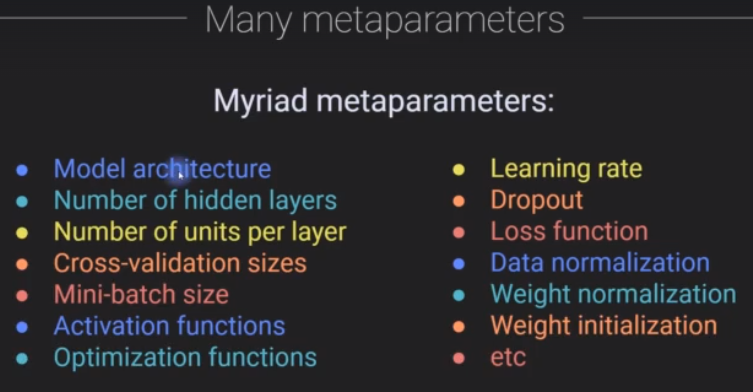

## Wine quality dataset

Measure various chemical properties of wine and predict how good it is.

In [45]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split

import numpy as np
import scipy.stats as stats

import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [31]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv"

data = pd.read_csv(url,sep=';')
data

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
1,7.8,0.880,0.00,2.6,0.098,25.0,67.0,0.99680,3.20,0.68,9.8,5
2,7.8,0.760,0.04,2.3,0.092,15.0,54.0,0.99700,3.26,0.65,9.8,5
3,11.2,0.280,0.56,1.9,0.075,17.0,60.0,0.99800,3.16,0.58,9.8,6
4,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
...,...,...,...,...,...,...,...,...,...,...,...,...
1594,6.2,0.600,0.08,2.0,0.090,32.0,44.0,0.99490,3.45,0.58,10.5,5
1595,5.9,0.550,0.10,2.2,0.062,39.0,51.0,0.99512,3.52,0.76,11.2,6
1596,6.3,0.510,0.13,2.3,0.076,29.0,40.0,0.99574,3.42,0.75,11.0,6
1597,5.9,0.645,0.12,2.0,0.075,32.0,44.0,0.99547,3.57,0.71,10.2,5


Likely target variable - "quality" with values ranging from 3-8

In [32]:
data.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000
mean,8.319637,0.527821,0.270976,2.538806,0.087467,15.874922,46.467792,0.996747,3.311113,0.658149,10.422983,5.636023
std,1.741096,0.179060,0.194801,1.409928,0.047065,10.460157,32.895324,0.001887,0.154386,0.169507,1.065668,0.807569
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000,3.000000
25%,7.100000,0.390000,0.090000,1.900000,0.070000,7.000000,22.000000,0.995600,3.210000,0.550000,9.500000,5.000000
50%,7.900000,0.520000,0.260000,2.200000,0.079000,14.000000,38.000000,0.996750,3.310000,0.620000,10.200000,6.000000
75%,9.200000,0.640000,0.420000,2.600000,0.090000,21.000000,62.000000,0.997835,3.400000,0.730000,11.100000,6.000000
max,15.900000,1.580000,1.000000,15.500000,0.611000,72.000000,289.000000,1.003690,4.010000,2.000000,14.900000,8.000000


In [33]:
# listing number of unique values per column

for i in data.keys():
    print(i, f'- {len(np.unique(data[i]))} unique values')

fixed acidity - 96 unique values
volatile acidity - 143 unique values
citric acid - 80 unique values
residual sugar - 91 unique values
chlorides - 153 unique values
free sulfur dioxide - 60 unique values
total sulfur dioxide - 144 unique values
density - 436 unique values
pH - 89 unique values
sulphates - 96 unique values
alcohol - 65 unique values
quality - 6 unique values


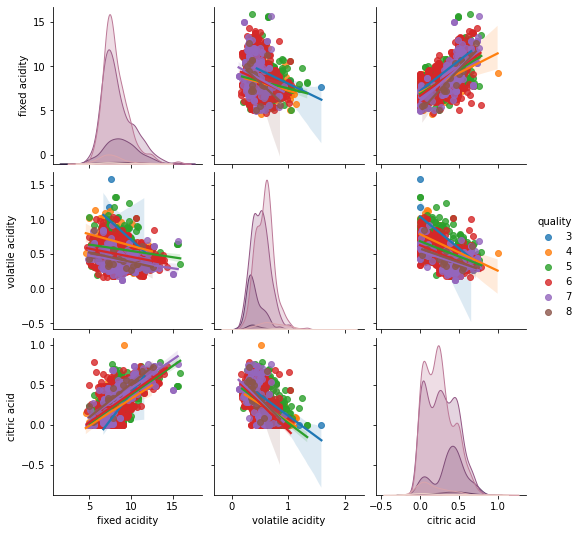

In [34]:
# pairwise plots
cols2plot = ['fixed acidity','volatile acidity','citric acid','quality']
sns.pairplot(data[cols2plot],kind='reg',hue='quality')
plt.show()

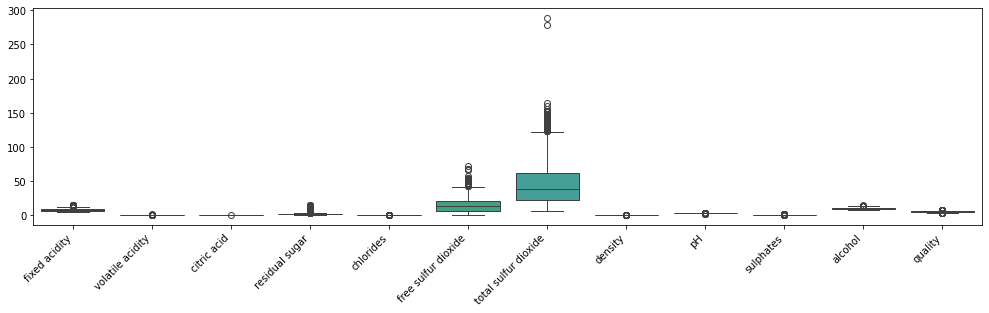

In [35]:
# plot some data
fig, ax = plt.subplots(1, figsize=(17, 4))
ax = sns.boxplot(data=data)
plt.xticks(rotation=45, ha="right")  # Set x-axis tick label rotation and alignment
plt.show()

We have outliers in rows of 'total sulfur dioxide'

In [36]:
# removing rows with outliers

data = data[data['total sulfur dioxide'] < 200]

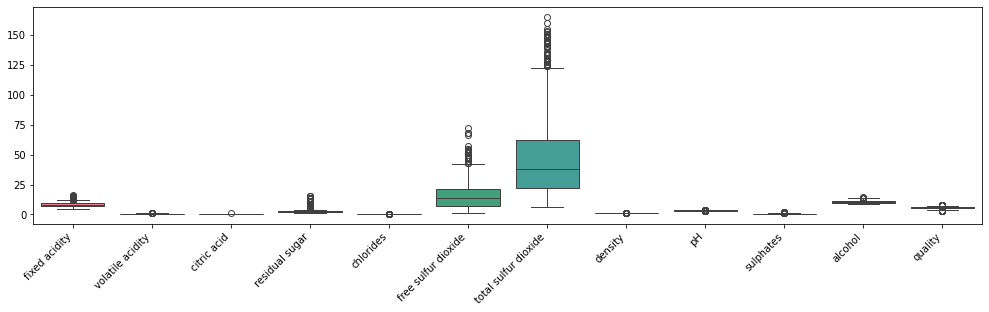

In [37]:
# plot some data
fig, ax = plt.subplots(1, figsize=(17, 4))
ax = sns.boxplot(data=data)
plt.xticks(rotation=45, ha="right")  # Set x-axis tick label rotation and alignment
plt.show()

Since rows have huge ranges, we can use z-score to normalize on all variables except target variable 'quality'

In [38]:
# z-score

zscoreCols = data.keys().drop('quality')

for i in zscoreCols:
    mean = np.mean(data[i])
    stdev = np.std(data[i], ddof=1)
    data[i] = (data[i] - mean)/stdev

# can also be done using the line below
# data[zscoreCols] = data[zscoreCols].apply(stats.zscore)

data.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,1.597000e+03,1.597000e+03,1.597000e+03,1.597000e+03,1.597000e+03,1.597000e+03,1.597000e+03,1.597000e+03,1.597000e+03,1.597000e+03,1.597000e+03,1597.000000
mean,1.779694e-17,1.156801e-16,1.779694e-17,-7.563699e-17,-1.512740e-16,-1.779694e-17,-7.118775e-17,-8.357442e-14,3.025479e-16,8.008622e-17,-5.872989e-16,5.634314
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.806630
min,-2.135419e+00,-2.280048e+00,-1.391387e+00,-1.168783e+00,-1.604073e+00,-1.422392e+00,-1.262186e+00,-3.545821e+00,-3.708218e+00,-1.936711e+00,-1.898626e+00,3.000000
25%,-7.003882e-01,-7.715838e-01,-9.283861e-01,-4.524372e-01,-3.720247e-01,-8.476045e-01,-7.594598e-01,-6.109478e-01,-6.585382e-01,-6.390204e-01,-8.650444e-01,5.000000
50%,-2.411785e-01,-4.528645e-02,-5.382836e-02,-2.375335e-01,-1.808448e-01,-1.770192e-01,-2.567340e-01,-6.214425e-04,-9.670044e-03,-2.261189e-01,-2.073106e-01,6.000000
75%,5.050372e-01,6.251419e-01,7.692848e-01,4.900487e-02,5.281955e-02,4.935662e-01,4.973546e-01,5.778618e-01,5.743113e-01,4.227263e-01,6.383472e-01,6.000000
max,4.350918e+00,5.876831e+00,3.753070e+00,9.289866e+00,1.112001e+01,5.379259e+00,3.733652e+00,3.682565e+00,4.532407e+00,7.913939e+00,4.208902e+00,8.000000


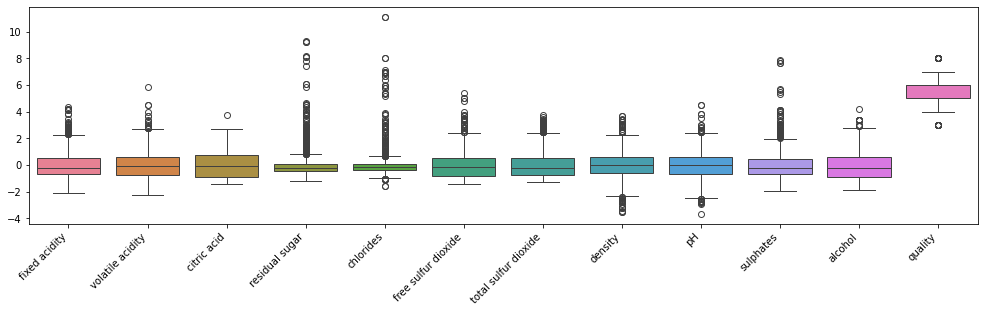

In [39]:
# plot some data
fig, ax = plt.subplots(1, figsize=(17, 4))
ax = sns.boxplot(data=data)
plt.xticks(rotation=45, ha="right")  # Set x-axis tick label rotation and alignment
plt.show()

We have to check the data distribution of 'quality' and see how they are represented. This helps us understand the kind of distribution each class holds.

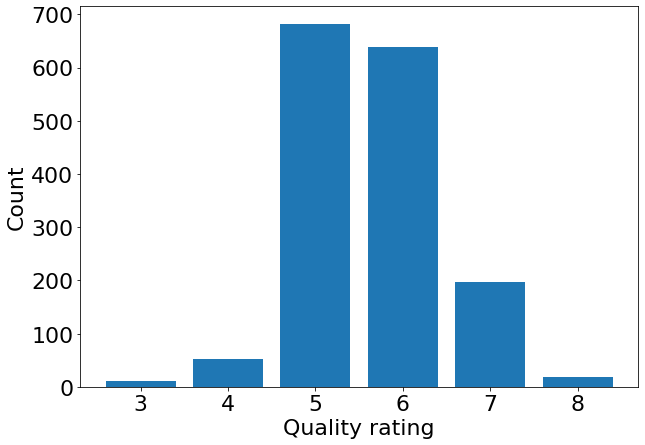

In [40]:
# distribution quality values
fig = plt.figure(figsize=(10,7))
plt.rcParams.update({'font.size': 22}) # increase font size in the figure

counts = data['quality'].value_counts()
plt.bar(list(counts.keys()),counts)
plt.xlabel('Quality rating')
plt.ylabel('Count')
plt.show()

There is a significant imbalance in the quality ratings which would affect the learnings of model. Hence we could binarize the quality by dividing into low and high qualities:

quality < 6 = 0, else 1

In [41]:
# create a new column for binarized (boolean) quality
data['boolQuality'] = 0
# data['boolQuality'][data['quality']<6] = 0 # implicit in the code! just here for clarity
data['boolQuality'][data['quality']>5] = 1

data[['quality','boolQuality']]

,quality,boolQuality
0,5,0
1,5,0
2,5,0
3,6,1
4,5,0
...,...,...
1594,5,0
1595,6,1
1596,6,1
1597,5,0


Reorganize the data into features and labels, and then into tensors, train, test, loaders etc:

In [43]:
data_t = torch.tensor(data[zscoreCols].values).float()
labels = torch.tensor(data['boolQuality'].values).float()

print(data_t.shape, labels.shape)

# convert labels into a 1D tensor
labels = labels[:, None]
labels.shape

torch.Size([1597, 11]) torch.Size([1597])


torch.Size([1597, 1])

In [46]:
X_train, X_test, y_train, y_test = train_test_split(data_t, labels, test_size=.2, shuffle=True)

train_data = TensorDataset(X_train, y_train)
test_data = TensorDataset(X_test, y_test)

batch_size = 64

trainLoader = DataLoader(train_data, batch_size=batch_size, shuffle=True, drop_last=True)
testLoader = DataLoader(test_data, batch_size=test_data.tensors[0].shape[0])

In [47]:
for X, y in trainLoader:
    print(X.shape, y.shape)

torch.Size([64, 11]) torch.Size([64, 1])
torch.Size([64, 11]) torch.Size([64, 1])
torch.Size([64, 11]) torch.Size([64, 1])
torch.Size([64, 11]) torch.Size([64, 1])
torch.Size([64, 11]) torch.Size([64, 1])
torch.Size([64, 11]) torch.Size([64, 1])
torch.Size([64, 11]) torch.Size([64, 1])
torch.Size([64, 11]) torch.Size([64, 1])
torch.Size([64, 11]) torch.Size([64, 1])
torch.Size([64, 11]) torch.Size([64, 1])
torch.Size([64, 11]) torch.Size([64, 1])
torch.Size([64, 11]) torch.Size([64, 1])
torch.Size([64, 11]) torch.Size([64, 1])
torch.Size([64, 11]) torch.Size([64, 1])
torch.Size([64, 11]) torch.Size([64, 1])
torch.Size([64, 11]) torch.Size([64, 1])
torch.Size([64, 11]) torch.Size([64, 1])
torch.Size([64, 11]) torch.Size([64, 1])
torch.Size([64, 11]) torch.Size([64, 1])


## Normalization

When magnitude is large, losses will also be huge which also affects the change in weights, and hence the process of learning for each feature will be different and overall inefficient.

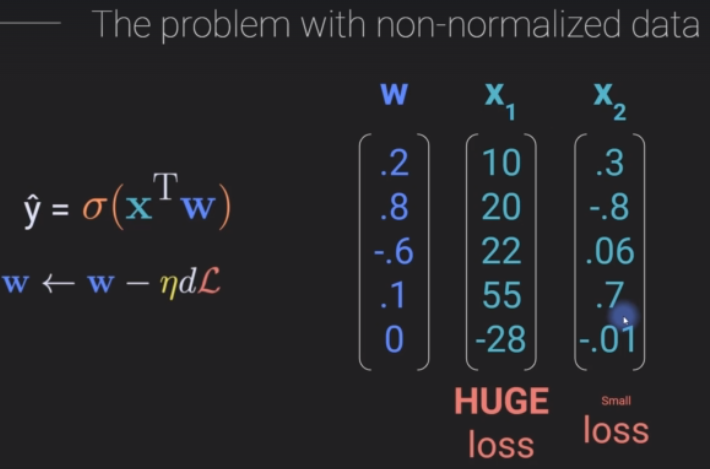

Normalization ensures that all data features are treated the same, and weights remain numerically stable.

- __Z-score__ - makes sure all features are in same range. It shifts and stretches but doesn't change shape
$$z_i = \frac{x_i - \bar{x_i}}{\sigma_x}$$

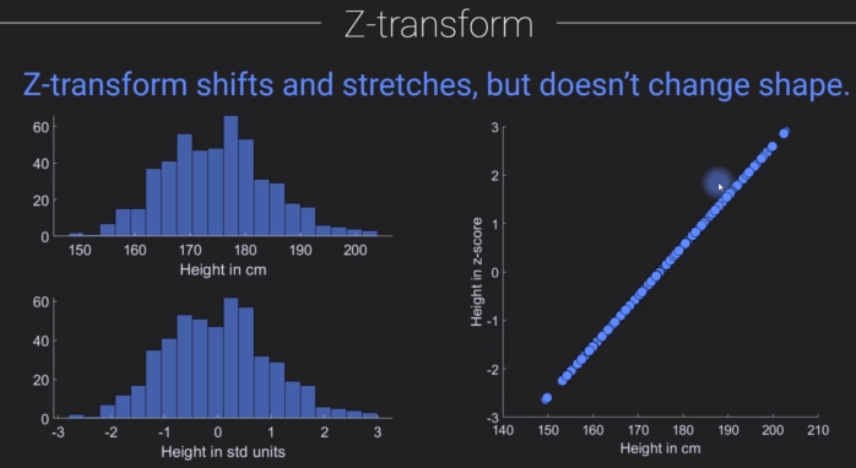



- __Min-max scaling__ - ensures data is between 0 and 1.
$$\tilde{x} = \frac{x - \min{x}}{\max{x} - \min{x}}$$

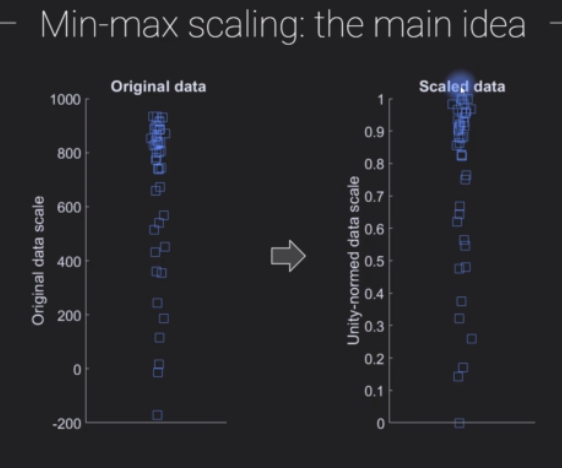


We can also rescale the data between __a__ to __b__ by $x^* = a + \tilde{x}(b - a)$

Min-Max scaling is common for uniform data and images.  
Z-scoring is common for data that are normally distributed or skewed or clustered.

## Batch Normalisation

Idea is to normalize not just raw input, but also the inputs going into each layer of NN.

Activation functions applied on output of each layer also affects the mean and other charactersitics of the data at that point. Hence, we cannot keep normalizing with the same mean and other charactersitcs of the input to the output of each layer. So, the better idea is to make mean and std as learnable parameters of NN.

Idea is to scale the raw input to $\gamma$ and shift it by $\beta$ as shown below:

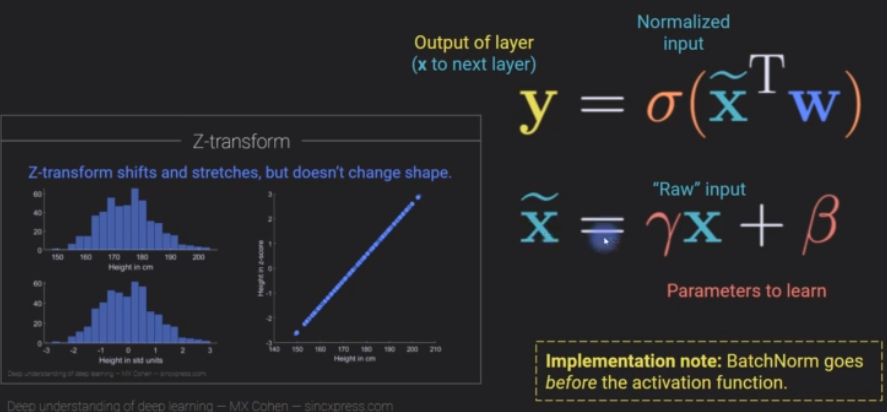

$\gamma$ is the learnable standard deviation and $\beta$ is the learnable mean parameter (because during normalization, we shift the data by mean and divide by standard deviation). So, now, $\tilde{x}$ is the input to the activation.

There are various opinions and research whether to normalize the data first and send it to activation, or send it to activation first and then normalize the data.

__Batch Normalization is applied only during training.__ It should be turned off for validation and testing data as it is applied on batches, and batch size could differ in val and test. It is automatically switched off with eval() mode in pytorch.

It is more useful for deep nets. It acts as a form of regularization. It is more suitable to call it as __layer normalization__.

### Implementation in Pytorch

In [77]:
def preprocess_data(data):
    
    # preprocess data as before
    data = data[data['total sulfur dioxide'] < 200]
    zscoreCols = data.keys().drop('quality')
    data[zscoreCols] = data[zscoreCols].apply(stats.zscore)
    data['boolQuality'] = 0
    data['boolQuality'][data['quality']>5] = 1 
    data_t = torch.tensor(data[zscoreCols].values).float()
    labels = torch.tensor(data['boolQuality'].values).float()
    labels = labels[:,None]
    return data_t, labels

def load_data(data, labels):
    
    X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=.2, shuffle=True)

    train_data = TensorDataset(X_train, y_train)
    test_data = TensorDataset(X_test, y_test)
    trainLoader = DataLoader(train_data, batch_size=32, shuffle=True, drop_last=True)
    testLoader = DataLoader(test_data, batch_size=test_data.tensors[0].shape[0])
    
    return trainLoader,  testLoader

In [78]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv"

data = pd.read_csv(url,sep=';')

data, labels = preprocess_data(data)
trainLoader, testLoader = load_data(data, labels)

In [83]:
# NN with Batch Normalization

class ANN_BNorm(nn.Module):
    def __init__(self):
        super().__init__()

        self.ip = nn.Linear(11, 16)   # ip layer
        self.bn1 = nn.BatchNorm1d(16)  # number of units that go into this layer
        self.h1 = nn.Linear(16, 32)   # hidden layer 1
        self.bn2 = nn.BatchNorm1d(32)  # number of units that go into this layer 
        self.h2 = nn.Linear(32, 20)  # hidden layer 2
        self.op = nn.Linear(20, 1)
    
    def forward(self, x, doBN):  # doBN is bool set to true for train, and false for test
        
        x = F.relu(self.ip(x))
        
        if doBN:
            x = self.bn1(x)
        
        x = F.relu(self.h1(x))
            
        if doBN:
            x = self.bn2(x)
        
        x = F.relu(self.h2(x))
        
#         else:
#             x = F.relu(self.h1(x))
#             x = F.relu(self.h2(x))
        
        return self.op(x)

In [84]:
# training the model

nEp = 1000

def trainModel(wine_net, doBN=True):
    lossfn = nn.BCEWithLogitsLoss()
    optim = torch.optim.SGD(wine_net.parameters(), lr = 0.01)
    
    losses = torch.zeros(nEp)
    trainAcc, testAcc = [], []
    
    for i in range(nEp):
        
        wine_net.train()
        
        batchLoss, batchAcc = [], []
        
        for x, y in trainLoader:
            
            yHat = wine_net(x, doBN)
            loss = lossfn(yHat, y)
            
            # backprop
            optim.zero_grad()
            loss.backward()
            optim.step()
            
            batchLoss.append(loss.item())
            batchAcc.append(100*torch.mean(((yHat>0)==y).float()).item())
        
        trainAcc.append(np.mean(batchAcc))
        losses[i] = np.mean(batchLoss)
        
        wine_net.eval()
        x, y = next(iter(testLoader))
        with torch.no_grad():
            yHat = wine_net(x, doBN)
        testAcc.append(100*torch.mean(((yHat>0)==y).float()).item())
          
    
    return trainAcc, testAcc, losses

In [87]:
wine_net = ANN_BNorm()
trainAccNA, testAccNA, lossesNA = trainModel(wine_net, False) # without batch norm

wine_net = ANN_BNorm()
trainAcc, testAcc, losses = trainModel(wine_net, True) # without batch norm

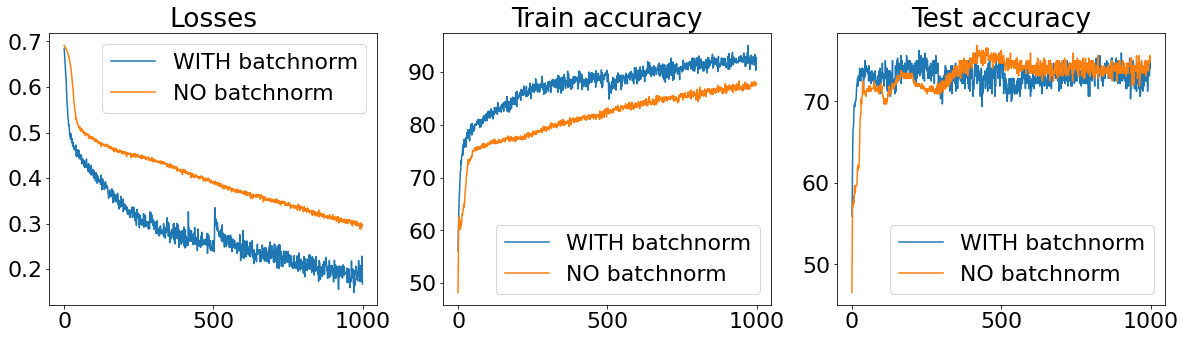

In [88]:
# plot the results
fig,ax = plt.subplots(1,3,figsize=(20,5))

ax[0].plot(losses,label='WITH batchnorm')
ax[0].plot(lossesNA,label='NO batchnorm')
ax[0].set_title('Losses')
ax[0].legend()

ax[1].plot(trainAcc,label='WITH batchnorm')
ax[1].plot(trainAccNA,label='NO batchnorm')
ax[1].set_title('Train accuracy')
ax[1].legend()

ax[2].plot(testAcc,label='WITH batchnorm')
ax[2].plot(testAccNA,label='NO batchnorm')
ax[2].set_title('Test accuracy')
ax[2].legend()

plt.show()

## Activation Functions

Some desirable quailities for activation functions :

- __For a hidden layer__ - non-linearity, computationally simple, avoiding limited range and vanishing/exploding gradient problem.
- __For an output layer__ - non-linear for classification, or linear for regression. Should be able to saturating in a range (say [0,1])  for converting to probabilities.

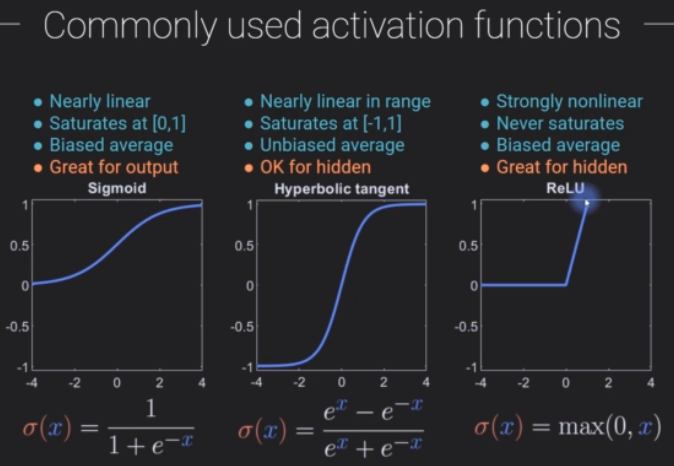

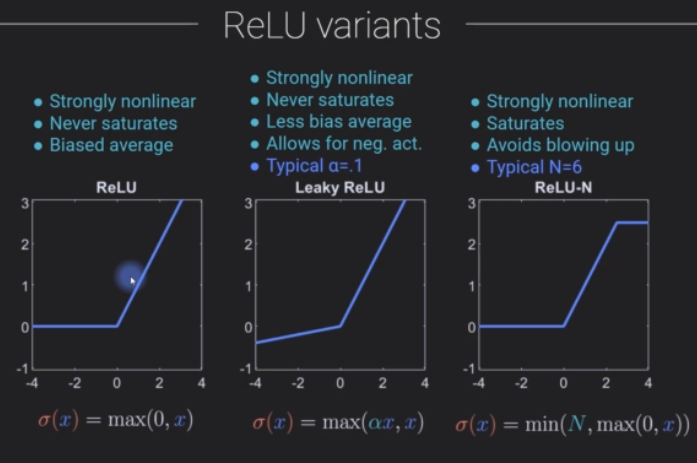

### Activation functions in practice

In [1]:
# import libraries
import torch
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size':18})

In [8]:
x = torch.linspace(-3, 3, 101) # creating data

def NNop(actFn):
    actFn = getattr(torch, actFn)
    return actFn(x)

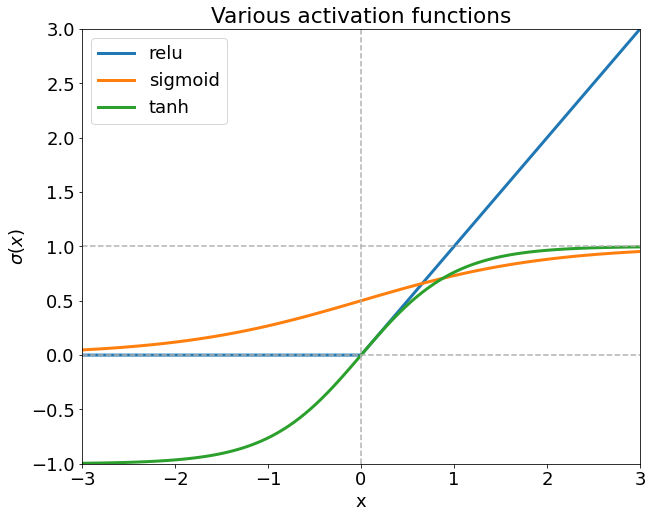

In [9]:
af  = ['relu', 'sigmoid', 'tanh']

fig = plt.figure(figsize=(10,8))

for i in af:
    plt.plot(x,NNop(i),label=i,linewidth=3)
    
# add reference lines
dashlinecol = [.7,.7,.7]
plt.plot(x[[0,-1]],[0,0],'--',color=dashlinecol)
plt.plot(x[[0,-1]],[1,1],'--',color=dashlinecol)
plt.plot([0,0],[-1,3],'--',color=dashlinecol)

# make the plot look nicer
plt.legend()
plt.xlabel('x')
plt.ylabel('$\sigma(x)$')
plt.title('Various activation functions')
plt.xlim(x[[0,-1]])
plt.ylim([-1,3])
plt.show()

#### Activation functions in torch.nn

In [18]:
def NNop(actFn):
    actFn = getattr(torch.nn, actFn)
    return actFn()

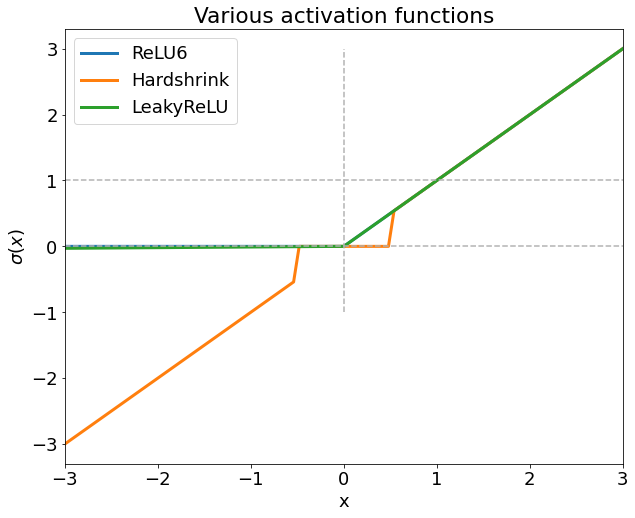

In [22]:
af = ['ReLU6', 'Hardshrink', 'LeakyReLU']

fig = plt.figure(figsize=(10,8))

for actfun in af:
  plt.plot(x,NNop(actfun)(x),label=actfun,linewidth=3)

# add reference lines
dashlinecol = [.7,.7,.7]
plt.plot(x[[0,-1]],[0,0],'--',color=dashlinecol)
plt.plot(x[[0,-1]],[1,1],'--',color=dashlinecol)
plt.plot([0,0],[-1,3],'--',color=dashlinecol)

# make the plot look nicer
plt.legend()
plt.xlabel('x')
plt.ylabel('$\sigma(x)$')
plt.title('Various activation functions')
plt.xlim(x[[0,-1]])
# plt.ylim([-1,3])
# plt.ylim([-.1,.1])
plt.show()

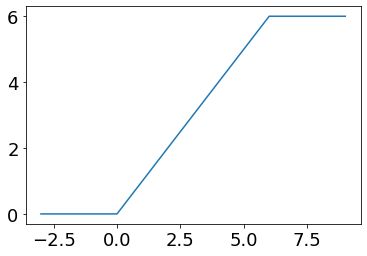

In [23]:
# relu6 in more detail
x = torch.linspace(-3,9,101)
relu6 = torch.nn.ReLU6()

plt.plot(x,relu6(x))
plt.show()

#### Difference in torch and torch.nn

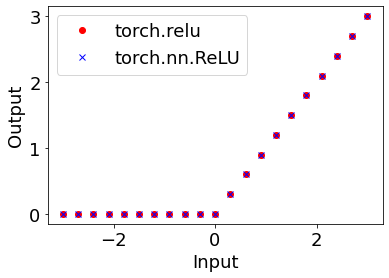

In [24]:
x = torch.linspace(-3,3,21)

y1 = torch.relu(x)

f = torch.nn.ReLU()
y2 = f(x)

# the results are the same
plt.plot(x,y1,'ro',label='torch.relu')
plt.plot(x,y2,'bx',label='torch.nn.ReLU')
plt.legend()
plt.xlabel('Input')
plt.ylabel('Output')
plt.show()

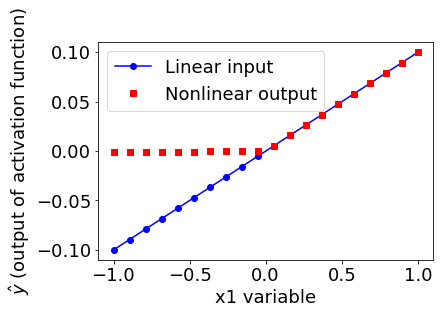

In [44]:
#  experimentation with different activation functions

x1 = torch.linspace(-1,1,20)
x2 = 2*x1

w1, w2 = -.1, .1

lin = w1*x1 + w2*x2 # linear combination

y = torch.nn.LeakyReLU()(lin)

# and plot!
plt.plot(x1,lin,'bo-',label='Linear input')
plt.plot(x1,y,'rs',label='Nonlinear output')
plt.ylabel('$\\hat{y}$ (output of activation function)')
plt.xlabel('x1 variable')
# plt.ylim([-.1,.1]) # optional -- uncomment and modify to zoom in
plt.legend()
plt.show()

### Activation functions comparision on wine dataset

In [46]:
def preprocess_data(data):
    
    # preprocess data as before
    data = data[data['total sulfur dioxide'] < 200]
    zscoreCols = data.keys().drop('quality')
    data[zscoreCols] = data[zscoreCols].apply(stats.zscore)
    data['boolQuality'] = 0
    data['boolQuality'][data['quality']>5] = 1 
    data_t = torch.tensor(data[zscoreCols].values).float()
    labels = torch.tensor(data['boolQuality'].values).float()
    labels = labels[:,None]
    return data_t, labels

def load_data(data, labels):
    
    X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=.2, shuffle=True)

    train_data = TensorDataset(X_train, y_train)
    test_data = TensorDataset(X_test, y_test)
    trainLoader = DataLoader(train_data, batch_size=32, shuffle=True, drop_last=True)
    testLoader = DataLoader(test_data, batch_size=test_data.tensors[0].shape[0])
    
    return trainLoader,  testLoader

url = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv"

data = pd.read_csv(url,sep=';')

data, labels = preprocess_data(data)
trainLoader, testLoader = load_data(data, labels)

In [72]:
# NN with Batch Normalization

class ANN_BNorm(nn.Module):
    def __init__(self, actfn):
        super().__init__()

        self.ip = nn.Linear(11, 16)   # ip layer
        self.bn1 = nn.BatchNorm1d(16)  # number of units that go into this layer
        self.h1 = nn.Linear(16, 32)   # hidden layer 1
        self.bn2 = nn.BatchNorm1d(32)  # number of units that go into this layer 
        self.h2 = nn.Linear(32, 20)  # hidden layer 2
        self.op = nn.Linear(20, 1)
        self.actfn = actfn
    
    def forward(self, x, doBN=True):  # doBN is bool set to true for train, and false for test
        
        actfn = getattr(torch, self.actfn)
        
        x = actfn(self.ip(x))
        
        if doBN:
            x = self.bn1(x)
        
        x = actfn(self.h1(x))
            
        if doBN:
            x = self.bn2(x)
        
        x = actfn(self.h2(x))
        
        return self.op(x)

In [73]:
# testing the model

net = ANN_BNorm('sigmoid')
net(torch.randn(10, 11)).shape

torch.Size([10, 1])

In [74]:
# training the model

nEp = 1000

def trainModel(wine_net, doBN=True):
    lossfn = nn.BCEWithLogitsLoss()
    optim = torch.optim.SGD(wine_net.parameters(), lr = 0.01)
    
    losses = torch.zeros(nEp)
    trainAcc, testAcc = [], []
    
    for i in range(nEp):
        
        wine_net.train()
        
        batchLoss, batchAcc = [], []
        
        for x, y in trainLoader:
            
            yHat = wine_net(x, doBN)
            loss = lossfn(yHat, y)
            
            # backprop
            optim.zero_grad()
            loss.backward()
            optim.step()
            
            batchLoss.append(loss.item())
            batchAcc.append(100*torch.mean(((yHat>0)==y).float()).item())
        
        trainAcc.append(np.mean(batchAcc))
        losses[i] = np.mean(batchLoss)
        
        wine_net.eval()
        x, y = next(iter(testLoader))
        with torch.no_grad():
            yHat = wine_net(x, doBN)
        testAcc.append(100*torch.mean(((yHat>0)==y).float()).item())
          
    
    return trainAcc, testAcc, losses

In [75]:
af = ['relu', 'tanh', 'sigmoid']

trAct = np.zeros((nEp, len(af)))
teAct = np.zeros((nEp, len(af)))

for i, AFn in enumerate(af):
    net = ANN_BNorm(AFn)
    trAct[:, i], teAct[:, i], losses = trainModel(net)

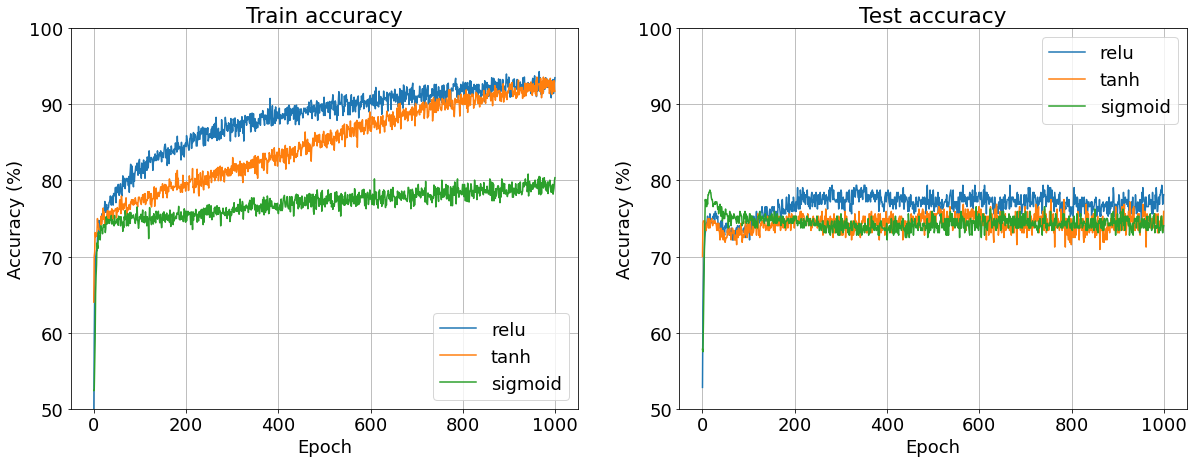

In [76]:
# plot some results
fig,ax = plt.subplots(1,2,figsize=(20,7))

ax[0].plot(trAct)
ax[0].set_title('Train accuracy')
ax[1].plot(teAct)
ax[1].set_title('Test accuracy')

# common features
for i in range(2):
  ax[i].legend(af)
  ax[i].set_xlabel('Epoch')
  ax[i].set_ylabel('Accuracy (%)')
  ax[i].set_ylim([50,100])
  ax[i].grid()

plt.show()